In [10]:
import pyemma as pm
from functions import discretize_trajectories, get_features, get_feature_traj_paths
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:

# dim 	lag 	k 	    feature 	y
# 9 	63 	    129 	contact_filtered 	2.801047
# 10 	144 	67 	    contact_filtered 	2.801575
# 10 	12 	    181 	contact_filtered 	2.805909
# 10 	104 	161 	phi_psi 	2.773073

In [7]:
def f(dim, lag, k):
    return {'vamp': {'dim': dim, 'lag': lag }, 'cluster_kmeans': {'k': k, 'max_iter': 1000}}
    

24-03-21 19:17:55 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[29] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


<AxesSubplot:xlabel='lag time / ns', ylabel='timescale / ns'>

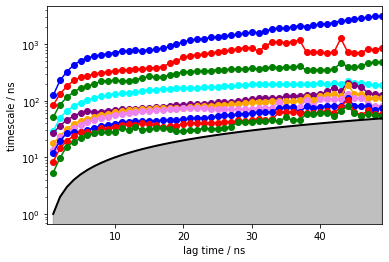

In [19]:
sim = 'transition_state'
feature = 'contact_filtered'
hps = f(9, 63, 129)
traj_paths = get_feature_traj_paths(sim_name=sim, feature=feature)
trajs = get_features(traj_paths)
dtrajs = discretize_trajectories(trajs=trajs, hyperparameters=hps)

timescales = pm.msm.its(dtrajs, lags=(np.arange(1, 50)*10).astype(int))

pm.plots.plot_implied_timescales(timescales, dt=0.1, units='ns', marker='o', nits=10)

24-03-21 19:18:46 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[36] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


<AxesSubplot:xlabel='lag time / ns', ylabel='timescale / ns'>

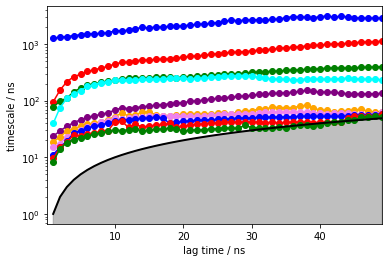

In [20]:
sim = 'transition_state'
feature = 'phi_psi'
hps = f(10, 104, 161)
traj_paths = get_feature_traj_paths(sim_name=sim, feature=feature)
trajs = get_features(traj_paths)
dtrajs = discretize_trajectories(trajs=trajs, hyperparameters=hps)

timescales = pm.msm.its(dtrajs, lags=(np.arange(1, 50)*10).astype(int))

pm.plots.plot_implied_timescales(timescales, dt=0.1, units='ns', marker='o', nits=10)

In [37]:
vamp = pm.coordinates.vamp(trajs, dim=10,lag=104)
y = vamp.get_output()
kmeans = pm.coordinates.cluster_kmeans(y, k=161, max_iter=1000)
z = kmeans.dtrajs
z = [x.flatten() for x in z]

mm = pm.msm.estimate_markov_model(z, lag=400)

active = mm.active_set

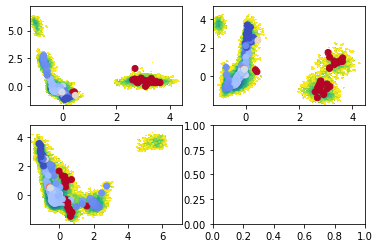

In [48]:
fig, axes = plt.subplots(2, 2)

for num, (i, j) in enumerate([(0, 1), (0, 2),(1, 2)]):
    all_y = np.concatenate(y)
    pm.plots.plot_free_energy(all_y[:, i],  all_y[:, j], cmap='viridis', ax=axes.flatten()[num], cbar=False)
    axes.flatten()[num].scatter(kmeans.cluster_centers_[active, i], kmeans.cluster_centers_[active, j], c=mm.eigenvectors_right()[:, 1], cmap='coolwarm')

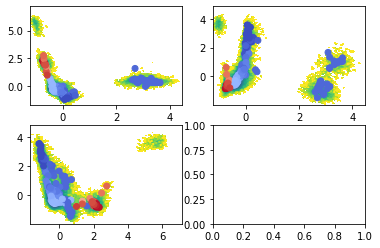

In [49]:
fig, axes = plt.subplots(2, 2)

for num, (i, j) in enumerate([(0, 1), (0, 2),(1, 2)]):
    all_y = np.concatenate(y)
    pm.plots.plot_free_energy(all_y[:, i],  all_y[:, j], cmap='viridis', ax=axes.flatten()[num], cbar=False)
    axes.flatten()[num].scatter(kmeans.cluster_centers_[active, i], kmeans.cluster_centers_[active, j], c=mm.eigenvectors_right()[:, 2], cmap='coolwarm')